In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# For use on local machine
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [ ]:
# For use in google colab
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd LIDC_GDRO/

In [ ]:
!git pull

In [ ]:
!git branch

In [3]:
from utils import data_utils, image_data_utils
import datasets
import dataloaders
import models
import torch
import loss
import train_eval
import pandas as pd
import numpy as np
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 128

hparams = {"eta": 0.01, "gamma": 1}
lr = 0.0005
weight_decay = 0.005

model_class = models.NeuralNetwork
model_args = (64, 36, 2)

# model_class = models.TransferModel50
# model_args = (True, True, device)


print(f'Using device {device}')

Using device cpu


# Load and process data

## LIDC

In [ ]:
# get LIDC data

df = data_utils.preprocess_data(*data_utils.load_lidc(data_root='data/', feature_path='LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv', subclass_path='subclass_labels/LIDC_data_split_with_cluster.csv'), subclass_column='cluster')
df

In [ ]:
# get train/test flags
train_split = pd.read_csv("data/train_test_splits/LIDC_data_split.csv")

# create train/test dataframes
train_df = df[df["noduleID"].isin(train_split[train_split["split"] == 0]["noduleID"].values)]
val_df = df[df["noduleID"].isin(train_split[train_split["split"] == 1]["noduleID"].values)]
test_df = df[df["noduleID"].isin(train_split[train_split["split"] == 2]["noduleID"].values)]

In [ ]:
train_dataloader = data_utils.create_dataloader(train_df, batch_size)
val_dataloader = data_utils.create_dataloader(val_df, len(val_df))
test_dataloader = data_utils.create_dataloader(test_df, len(test_df))

## LIDC CNN features

In [ ]:
cnn_train, cnn_val, cnn_test = image_data_utils.get_cnn_features(split_file='./data/subclass_labels/LIDC_data_split_with_cluster.csv')

In [ ]:
train_dataloader = data_utils.create_dataloader(cnn_train, batch_size=batch_size, is_dataframe=False)
val_dataloader = data_utils.create_dataloader(cnn_val, batch_size=batch_size, is_dataframe=False)
test_dataloader = data_utils.create_dataloader(cnn_test, batch_size=batch_size, is_dataframe=False)

## Waterbirds

In [ ]:
# download waterbirds through wilds

!pip install wilds
from wilds import get_dataset

get_dataset(dataset="waterbirds", download=True)

In [ ]:
from PIL import Image

In [ ]:
metadata_df = pd.read_csv('data/waterbirds_v1.0/metadata.csv')

In [ ]:
convert_resize = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((200, 200), antialias=True)])

train_df, val_df, test_df = [metadata_df[metadata_df['split'] == split] for split in [0, 1, 2]]

dataset_list = []

# If GPU memory is limited, images can be loaded as they are required
# This is much slower but may be necessary
# If false, all images are loaded up-front, which is also slow but only happens once
on_demand = False

for df in [train_df, val_df, test_df]:
    if on_demand:
        dataset_list.append(datasets.OnDemandImageDataset(df, 'data/waterbirds_v1.0/', transform=convert_resize, device=device))
    else:
        img_tensors = []
        for i in range(len(df.index)):
            img_path = metadata_df.iloc[i, 1]
            img_tensors.append(convert_resize(Image.open('data/waterbirds_v1.0/' + img_path)).squeeze().to(device))
        features = torch.stack(img_tensors)
        labels = torch.LongTensor([metadata_df.iloc[:, 2]]).squeeze().to(device)
        subclasses = torch.LongTensor([2 * metadata_df.iloc[:, 2] + metadata_df.iloc[:, 4]]).squeeze().to(device)

        dataset_list.append(datasets.SubclassedDataset(features, labels, subclasses))

In [ ]:
# smaller dataloaders for prototyping
train_dataloader, val_dataloader, test_dataloader = [dataloaders.InfiniteDataLoader(torch.utils.data.Subset(dataset, range(0, len(dataset), 2)), batch_size=batch_size) for dataset in dataset_list]

In [ ]:
# full size dataloaders
train_dataloader, val_dataloader, test_dataloader = [dataloaders.InfiniteDataLoader(dataset, batch_size=batch_size) for dataset in dataset_list]


# Test convergence of combinations of ERM and GDRO

In [ ]:
N = 100
epochs = 100
# subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]
# subtypes = ["Overall", "Land on land", "Land on water", "Water on land", "Water on water"]
subtypes = ["Overall", "Benign", "Malignant1", "Malignant2"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Dynamic", "ExtraERM", "ExtraGDRO", "Halfway"]
# test_algorithms = ["Mix" + str(t) for t in [0.4, 0.5, 0.6, 0.7, 0.8]]
# test_algorithms = ["ERM", "GDRO", *["Dynamic" + str(t) for t in [0.01, 0.05, 0.1, 0.5]]]
test_algorithms = ["ERM", "GDRO", "Dynamic", "Upweight"]
keep_old =        [False, False, False, False]

record_roc_data = False

In [6]:
if not sum(keep_old):
    results = {}
    if record_roc_data:
        roc_data = {}  # For ROC curve

for a in range(len(test_algorithms)):
    algorithm = test_algorithms[a]

    if keep_old[a] and algorithm in results:
        print(f"Keeping old results for {algorithm}")
    else:
        print(f"Running test: {algorithm}")

        results[algorithm] = np.zeros(N * epochs * len(subtypes))
        if record_roc_data:
            roc_data[algorithm] = [None, None]

        for n in range(N):

            print(f"Trial {n + 1}/{N}")

            # create and train model
            # model = models.NeuralNetwork(64, 32, 32, 2)
            # model.to(device)
            model = model_class(*model_args).to(device)

            if (algorithm == "ERM"):
                loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss(), subclassed=True)
            elif (algorithm == "GDRO"):
                loss_fn = loss.GDROLoss(model, torch.nn.CrossEntropyLoss(), hparams["eta"], len(subtypes) - 1, normalize_loss=False)
            elif (algorithm == "NormGDRO"):
                loss_fn = loss.GDROLoss(model, torch.nn.CrossEntropyLoss(), hparams["eta"], len(subtypes) - 1, normalize_loss=True)
            elif (algorithm.startswith("GDRO")):
                loss_fn = loss.GDROLoss(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("GDRO"):]), len(subtypes) - 1, normalize_loss=True)
            elif (algorithm == "Dynamic"):
                loss_fn = loss.DynamicLoss(model, torch.nn.CrossEntropyLoss(), hparams["eta"], hparams["gamma"], len(subtypes) - 1)
            elif (algorithm.startswith("Dynamic")):
                loss_fn = loss.DynamicLoss(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("Dynamic"):]), hparams["gamma"], len(subtypes) - 1)
            elif (algorithm == "Upweight"):
                loss_fn = loss.UpweightLoss(model, torch.nn.CrossEntropyLoss(), len(subtypes) - 1)
            else:
                loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, len(subtypes) - 1)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)#, momentum=momentum)

            # scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)
            
            for epoch in range(epochs):
                print(f'Epoch {epoch + 1} / {epochs}')

                if algorithm == "Sharp":
                    loss_fn.t = epoch / epochs < 0.5  # sharp boundary
                elif algorithm == "Smooth":
                    loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
                elif algorithm == "ReverseSmooth":
                    loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
                elif algorithm == "ExtraERM":
                    loss_fn.t = 2
                elif algorithm == "ExtraGDRO":
                    loss_fn.t = -1
                elif algorithm == "Halfway":
                    loss_fn.t = 0.5
                elif algorithm.startswith("Mix"):
                    loss_fn.t = float(algorithm[3:])  # ex. algorithm == "Mix0.5" => t = 0.5

                train_eval.train(train_dataloader, model, loss_fn, optimizer)
                sensitivities = train_eval.evaluate(test_dataloader, model, num_subclasses=len(subtypes) - 1)
                
                # scheduler.step(train_eval.evaluate(val_dataloader, model, num_subclasses=len(subtypes) - 1)[0])

                for i in range(len(subtypes)):
                    results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]
            if record_roc_data:
                with torch.no_grad():
                    preds = model(torch.stack(test_dataloader.dataset.features))
                    probabilities = torch.nn.functional.softmax(preds, dim=1)[:, 1]
                    labels = test_dataloader.dataset.labels
                    if roc_data[algorithm][0] == None:
                        roc_data[algorithm][0] = probabilities
                        roc_data[algorithm][1] = labels
                    else:
                        roc_data[algorithm][0] += probabilities
        if record_roc_data:
            roc_data[algorithm][0] /= N
        
print("Test complete")

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

# Automatically save and download results from colab
# from datetime import datetime
# results_df.to_csv(f'results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv')

# from google.colab import files
# files.download(f'results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv') 

NameError: name 'keep_old' is not defined

In [ ]:
from datetime import datetime
results_df.to_csv(f'results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')

from google.colab import files
files.download(f'results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv') 

# Results Visualization

Data loading and plotting functions to visualize the results given by run.py  
Put the path of the folder containing the results in load_dir and run the cells to see results

In [322]:
import matplotlib.pyplot as plt
load_root = 'test_results/standardized/'
load_dirs = [
    'LIDC_CNN_features_CNN_clusters_20220721_124206/',
    'LIDC_CNN_features_mal_groups_20220721_124332/',
    'LIDC_CNN_features_spic_groups_20220721_124328/',
    'LIDC_designed_features_CNN_clusters_20220721_123221/',
    'LIDC_designed_features_mal_groups_20220721_123917/',
    'LIDC_designed_features_spic_groups_20220721_123936/',
    'weight_decay=1.0/LIDC_CNN_features_CNN_clusters_reg_20220721_162108/',
    'weight_decay=1.0/LIDC_CNN_features_mal_groups_reg_20220721_162211/',
    'weight_decay=1.0/LIDC_CNN_features_spic_groups_reg_20220721_162436/',
    'weight_decay=1.0/LIDC_designed_features_CNN_clusters_reg_20220721_161237/',
    'weight_decay=1.0/LIDC_designed_features_mal_groups_reg_20220721_161806/',
    'weight_decay=1.0/LIDC_designed_features_spic_groups_reg_20220721_161347/',
]

## Plot overall accuracy, subclass sensitivites, and worst sensitivity per epoch

In [329]:
def plot_acc():
    loaded_accuracies = pd.read_csv(load_dir + 'accuracies.csv')
    N = max(loaded_accuracies["trial"]) + 1
    epochs = max(loaded_accuracies["epoch"]) + 1
    subtypes = list(loaded_accuracies["subtype"].unique())
    algorithms = loaded_accuracies.columns

    results = loaded_accuracies.drop(columns=["subtype", "epoch", "trial"]).to_dict('list')
    results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

    trial_means = results_df.unstack().unstack().mean(axis=0).unstack(level=0).unstack(level=0).stack()
    worst_group = trial_means.stack().unstack(level=1).drop(columns="Overall").min(axis=1).unstack()
    worst_group.index = pd.MultiIndex.from_tuples([(epoch, "Worst") for epoch in worst_group.index], names=["epoch", "subtype"])
    trial_means = pd.concat([trial_means, worst_group])

    rolling_window = 1

    drop_epochs = []  # list(range(40, 100))

    rolling_data = trial_means.unstack(level=1).rolling(rolling_window).mean().stack().drop(drop_epochs, level=0, axis=0, inplace=False)
    # reindex epochs from 1
    rolling_data.index = pd.MultiIndex.from_tuples(zip(rolling_data.index.get_level_values(0) + 1, rolling_data.index.get_level_values(1)), names=["epoch", "subtype"])

    plots = [*subtypes, "Worst"]
    # plots = ["Overall", "Worst"]

    hide = []

    w = 2

    f, a = plt.subplots((len(plots) + 1) // w, w, sharey=True)

    if len(plots) > w:
        a = [ax for a0 in a for ax in a0]

    # plot subtypes sensitivity

    #legend=None,xlim=[35, 40],ylim=[0.85,0.88],

    for i in range(len(plots)):
        rolling_data.drop(columns=hide).xs(plots[i], level=1).plot(ylim=[0.5,1],xlabel="Epoch",ylabel="Accuracy",kind='line',title=plots[i],ax=a[i],figsize=(12 * w, 6 * ((len(plots) + 1) // w)),grid=True)

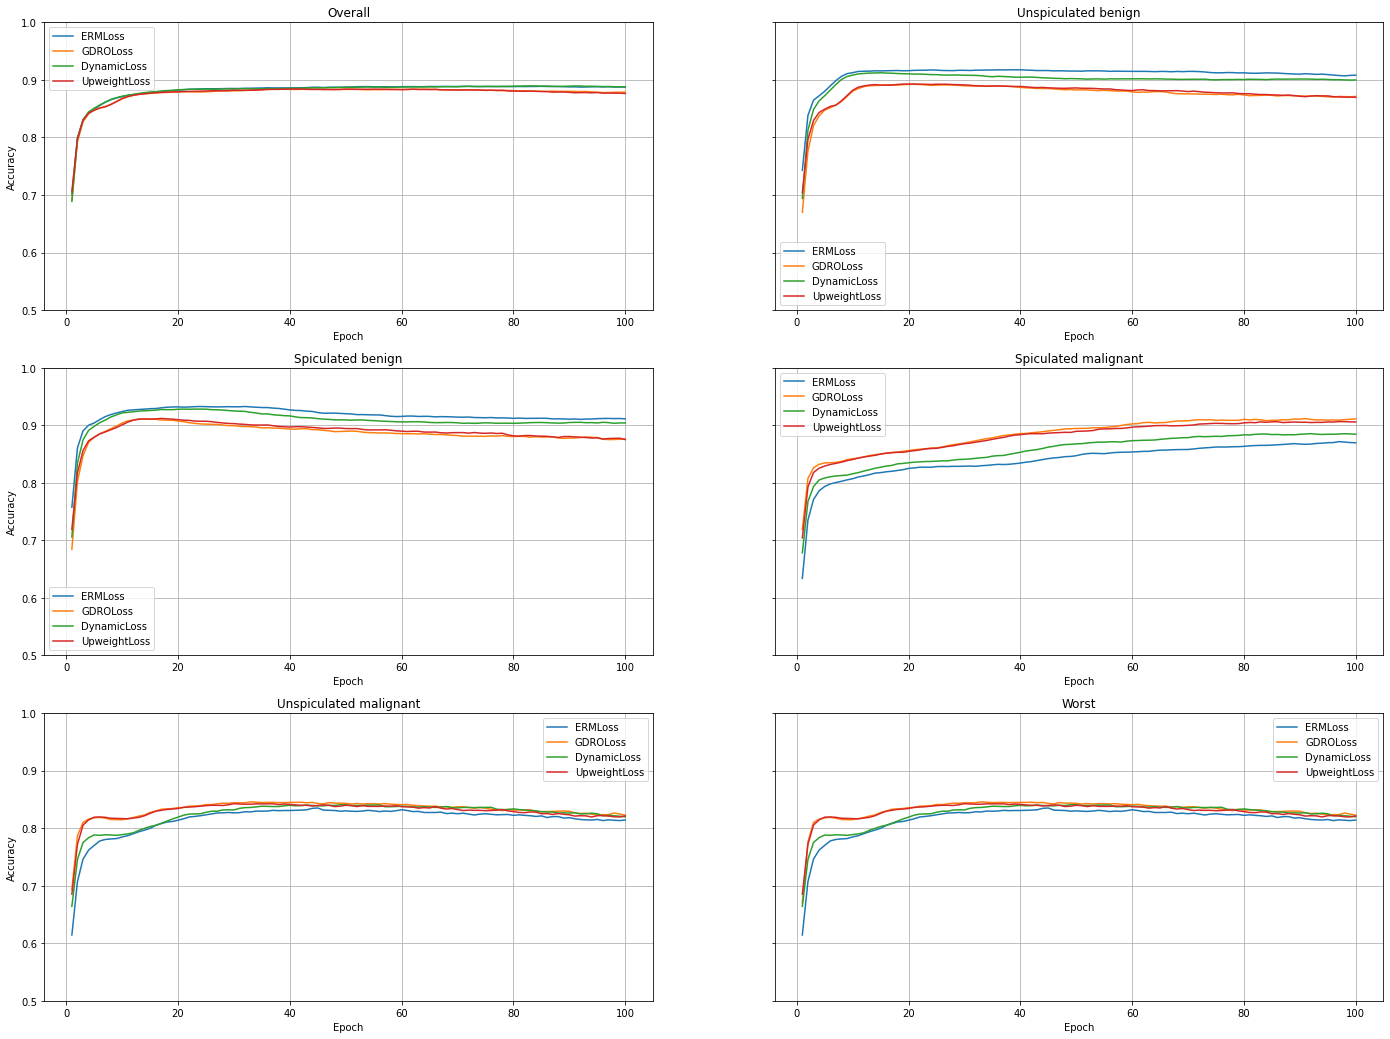

In [341]:
load_dir = load_root + load_dirs[5]
plot_acc()

## Plot values of q and g (subclass and loss function weights, respectively)

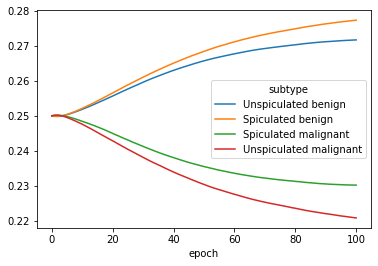

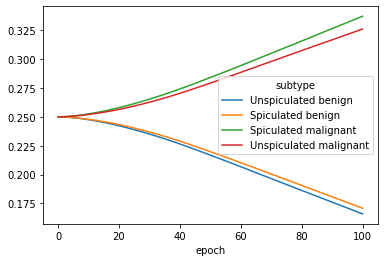

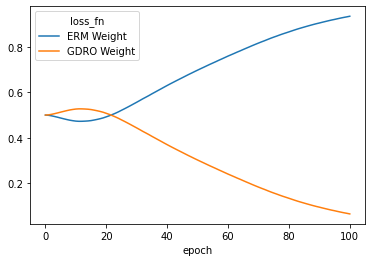

In [336]:
def read_q(path):
    loaded_data = pd.read_csv(load_dir + 'q.csv').dropna(axis=1)
    loaded_data.index = pd.MultiIndex.from_arrays([loaded_data['trial'], loaded_data['epoch'], loaded_data['subtype']], names=['trial', 'epoch', 'subtype'])
    saved_subtypes = loaded_data['subtype']
    loaded_data.drop(columns=['trial', 'epoch', 'subtype'], inplace=True)
    loaded_data = loaded_data.stack().unstack(level=1)
    loaded_data.insert(0, -1, np.ones(len(loaded_data.index)) / len(loaded_data.index.levels[1]))
    loaded_data.columns += 1
    mean_data = loaded_data.stack(level=0).unstack(level=0).mean(axis=1).unstack(level=0).stack(level=0).unstack(level=0)
    mean_data = mean_data.unstack(level=1)
    mean_data = mean_data.loc[:, pd.MultiIndex.from_product([mean_data.columns.levels[0], saved_subtypes.unique()])]
    return mean_data

def read_g(path):
    loaded_data = pd.read_csv(load_dir + 'g.csv').dropna(axis=1)
    loaded_data.index = pd.MultiIndex.from_arrays([loaded_data['trial'], loaded_data['epoch'], loaded_data['loss_fn']], names=['trial', 'epoch', 'loss_fn'])
    saved_subtypes = loaded_data['loss_fn']
    loaded_data.drop(columns=['trial', 'epoch', 'loss_fn'], inplace=True)
    loaded_data = loaded_data.stack().unstack(level=1)
    loaded_data.insert(0, -1, np.ones(len(loaded_data.index)) / len(loaded_data.index.levels[1]))
    loaded_data.columns += 1
    mean_data = loaded_data.stack(level=0).unstack(level=0).mean(axis=1).unstack(level=0).stack(level=0).unstack(level=0)
    mean_data = mean_data.unstack(level=1)
    mean_data = mean_data.loc[:, pd.MultiIndex.from_product([mean_data.columns.levels[0], saved_subtypes.unique()])]
    return mean_data

mean_q = read_q(load_dir + 'q.csv')

for c in mean_q.columns.levels[0]:
    mean_q[c].plot()
    
mean_g = read_g(load_dir + 'g.csv')
for c in mean_g.columns.levels[0]:
    mean_g[c].plot()

## Plot ROC Curve

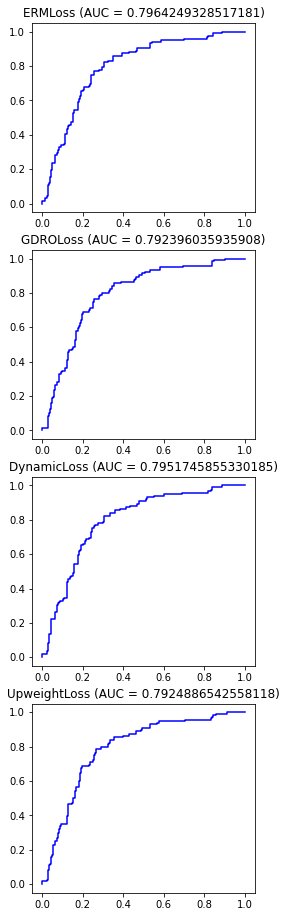

In [310]:
# ROC curve

from sklearn import metrics

roc_df = pd.read_csv(load_dir + 'ROC.csv')

f, a = plt.subplots(len(roc_df.columns) - 1, 1, figsize=(4,4 * (len(roc_df.columns) - 1)))

for i in range(len(roc_df.columns) - 1):
    c = roc_df.drop(columns='labels').columns[i]
    
    y_true = roc_df['labels']
    y_score = roc_df[c]

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    a[i].plot(fpr, tpr, 'b')
    a[i].set_title(f'{c} (AUC = {auc})')

In [ ]:
# statisitical tests comparing to ERM
from scipy.stats import ttest_ind
from IPython.display import display
import seaborn as sns

significance_threshold = 0.05

ttest_dataframes = {}

f, a = plt.subplots(len(subtypes) + 1,1, sharey=True, figsize=(8,32))

for s in range(len(subtypes)):
#     print(subtype)
#     print()
    subtype_data = results_df.xs(subtypes[s], level=2).xs(epochs - 1, level=1)
    subtype_data.plot(title=subtypes[s], kind='box', ax=a[s])
    
    # worst group data
    # results_df.stack().unstack(level=2).min(axis=1).unstack().xs(epochs - 1, level=1).plot(title='worst', kind='box', ax=a[-1])

    
    erm_data = subtype_data["ERMLoss"].values

    print(subtypes[s])
    for algorithm in results_df.columns:
        if algorithm != "ERMLoss":
            algorithm_data = subtype_data[algorithm].values
            stat, p = ttest_ind(algorithm_data, erm_data)

            print(f'ERMLoss: {erm_data.mean()}')
            print(f'{algorithm}: {algorithm_data.mean()}')
            if p < significance_threshold:
                print(f'{algorithm if stat > 0 else "ERMLoss"} greater with p = {p:.2f}')
            else:
                print(f'No significant difference with p = {p:.2f}')
            print()
    print()

In [ ]:
results_df.xs(subtype, level=2).xs(epochs - 1, level=1)

In [ ]:
# save results
results_df.to_csv('test_results/LIDC__fc64_36_36_2__Adam__eta_0_05__gamma_1_0__lr_0_001__weightdecay_0_0001__momentum_0_9.csv')

# GDRO Demonstration

In [ ]:
epochs = 30
N = 1

q_data = {}

for n in range(N):

    q_data[f'Trial_{n}'] = []
    
    model = model_class(*model_args).to(device)

    loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams["eta"], len(subtypes) - 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn.t = 0

    q_data[f'Trial_{n}'].extend([1 / (len(subtypes) - 1) for i in range(len(subtypes) - 1)])
    for epoch in range(epochs):
        train_eval.train(train_dataloader, model, loss_fn, optimizer)
        q_data[f'Trial_{n}'].extend(loss_fn.gdro.q.tolist())

# Combining CNN features and engineered features

In [ ]:
cnn_df = pd.read_csv('data/cnn_features.csv')
for c in range(2, len(cnn_df.columns)):
    cnn_df.columns.values[c] = f'CNN_{cnn_df.columns.values[c]}'

eng_df = pd.read_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [ ]:
cnn_df = cnn_df[cnn_df['nodule_id'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]
eng_df = eng_df[eng_df['noduleID'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]

In [ ]:
concat_df = eng_df.copy()

In [ ]:
cnn_df.index = cnn_df['nodule_id']
for i in concat_df.index:
    for col in cnn_df.columns[2:]:
        concat_df.at[i, col] = cnn_df.at[concat_df.at[i, 'noduleID'], col]

In [ ]:
concat_df.drop(columns='Unnamed: 0').to_csv('data/AllFeatures2D_MaxSlice_with_CNN.csv', index=False)

In [ ]:
feature_file='./data/erm_cluster_cnn_features_1.csv'
split_file='./data/subclass_labels/LIDC_data_split_with_cluster.csv'
device='cpu'
subclass='cluster'
df_features = pd.read_csv(feature_file, index_col=0)
df_splits = pd.read_csv(split_file, index_col=0)
df = df_features.sort_values('noduleID')
df['clusters'] = df_splits[subclass]
df['malignancy_b'] = df_splits['malignancy_b']

dfs = []
for i in range(3):
    dfs.append(df[df_splits['split'] == i])

datas = []
for d in dfs:
    X = torch.unbind(
        torch.tensor(d.drop(['noduleID', 'clusters', 'malignancy_b'], axis=1).values,
                     device=device, dtype=torch.float32))
    y = torch.unbind(torch.tensor(d['malignancy_b'].values, device=device))
    c = torch.unbind(torch.tensor(d['clusters'].values, device=device))
    datas.append((X, y, c))

In [ ]:
dfs[0].head()

In [ ]:
x = [1,2,3,4,5]
y = [6,7,8,9,10]
c = [0,0,0,0,0]
dl = dataloaders.InfiniteDataLoader(datasets.SubclassedDataset(x, y, c), batch_size=5)

In [ ]:
next(dl)

In [ ]:
dl = iter(torch.utils.data.DataLoader(
            datasets.SubclassedDataset(x, y, c),
            batch_size=5
        ))

In [ ]:
next(iter(dl))

In [ ]:
torch.stack([torch.Tensor([1])])

In [ ]:
sum(pd.read_csv('data/subclass_labels/LIDC_data_split_with_cluster.csv')['cluster'] == 0)

In [ ]:
sum(pd.read_csv('data/subclass_labels/LIDC_data_split_with_cluster.csv')['cluster'] == 1)

In [ ]:
sum(pd.read_csv('data/subclass_labels/LIDC_data_split_with_cluster.csv')['cluster'] == 2)